In [5]:
#Generalized resonator caluculator
#Jonathan Hoh 11/20/2019

In [1]:
#import packages
import skrf as rf
from skrf import plotting as nplt
from matplotlib import pyplot as plt
import numpy as np

In [143]:
#make a generalized form for reading in files
#accepts n number of touchstone files stored in "data"
data = ['155restme.s2p', '155modme.s2p', '155mod2me.s2p', '155mod3me.s2p', '155mod4me.s2p', '155mod5me.s2p']
#data = ['155restham.s2p', '155modham.s2p', '155mod2ham.s2p', '155mod3ham.s2p']
#data = ['477restme.s2p', '477modme.s2p', '477mod2me.s2p', '477mod3me.s2p', '477mod4me.s2p']
colors = ['b', 'g', 'c', 'm', 'y', 'k']
n = len(data)
mags = []
devs = []
freqs = []
angs = []

def params(n, data):
    for i in range(n):
        ntwk = rf.Network(data[i])
        s21 = ntwk.s[:,1,0]
        mag = []
        for i in range(len(s21)):
            mag.append(20*np.log10(np.abs(s21[i])))
        mags.append(mag)
        freq = []
        for i in range(len(ntwk.frequency.f)):
            freq.append(ntwk.frequency.f[i])
        freqs.append(freq)
        ang_raw = []
        for i in range(len(s21)):
            ang_raw.append(np.angle(s21[i]))
        ang = list(np.unwrap(ang_raw)*180/np.pi)
        angs.append(ang)
params(n, data)
for i in range(n):
    grad = np.gradient(mags[i])
    devs.append(list(grad))

Text(0, 0.5, 'Magnitude (dB)')

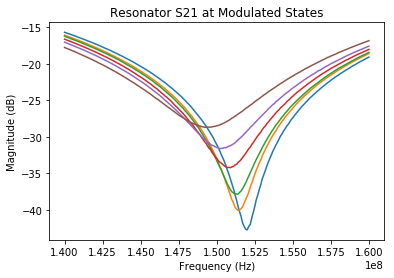

In [163]:
#plot and compare s21
for i in range(n):
    plt.plot(freqs[i],mags[i])
plt.title('Resonator S21 at Modulated States')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

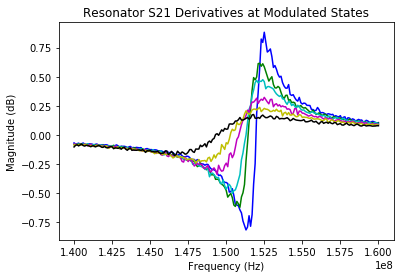

In [164]:
#plot derivatives of s21 to see if this helps at all with finding resonance
#because why the hell not
devmin = []
devminloc = []
for i in range(n):
    plt.plot(freqs[i],devs[i], color = colors[i])
    devmin.append(min(devs[i]))
plt.title('Resonator S21 Derivatives at Modulated States')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
devlist = list(devs)
for i in range(n):
    devminloc.append(devlist[i].index(devmin[i]))

Text(0, 0.5, 'Magnitude (dB)')

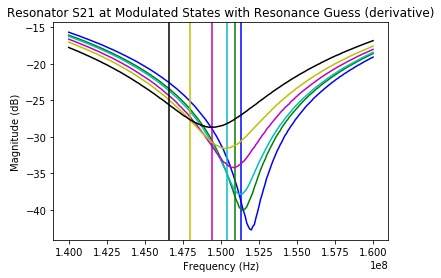

In [168]:
for i in range(n):
    plt.plot(freqs[i],mags[i], color = colors[i])
    plt.axvline(x=freqs[i][devminloc[i]], color = colors[i])
plt.title('Resonator S21 at Modulated States with Resonance Guess (derivative)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

Text(0, 0.5, 'Phase Angle (degrees)')

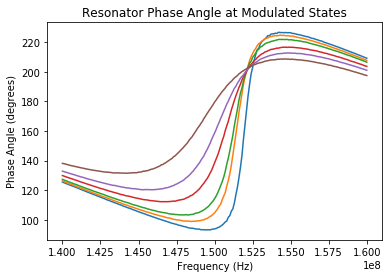

In [166]:
#plot and compare phases
for i in range(n):
    plt.plot(freqs[i],angs[i])
plt.title('Resonator Phase Angle at Modulated States')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Angle (degrees)')

In [148]:
low = []
loc = []
res = []
for i in range(n):
    low.append(min(mags[i]))
    loc.append(mags[i].index(min(mags[i])))
    res.append(freqs[i][loc[i]])

In [149]:
low

[-42.74817750896881,
 -40.063968403883614,
 -37.846955187740754,
 -34.22248628133142,
 -31.609716789536986,
 -28.68644849747087]

In [150]:
loc

[120, 114, 114, 109, 102, 93]

In [151]:
res

[152000000.0, 151400000.0, 151400000.0, 150900000.0, 150200000.0, 149300000.0]

In [152]:
def shift(m,n):
    shift = res[m]-res[n]
    return shift

In [153]:
shift(0,1)

600000.0

Text(0, 0.5, 'Magnitude (dB)')

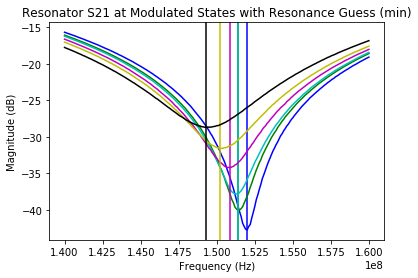

In [167]:
#plot resonance guesses
for i in range(n):
    plt.plot(freqs[i],mags[i], color = colors[i])
    plt.axvline(x=res[i], color = colors[i])
plt.title('Resonator S21 at Modulated States with Resonance Guess (min)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

In [106]:
#find resonant phase angle for each modulation
phi0 = []
for i in range(n):
    phi0.append(angs[i][loc[i]]);
phi0_av = sum(phi0)/len(phi0)
def error(n):
    error = np.abs(phi0_av-phi0[n])
    return error
phi0_rest = phi0[0]
phi0_av = sum(phi0)/len(phi0)
#for good measure, lets mark the frequency that relates to phi0 and see if its close to resonance
points = []
for i in range(n):
    minz = np.zeros(len(angs[i]))
    for j in range(len(angs[i])):
        minz[j] = (abs(phi0_av-angs[i][j]))
    minlist = list(minz)
    minmin = min(minlist)
    points.append(minlist.index(minmin))    

In [107]:
points

[120, 115, 113, 109, 103, 91]

Text(0, 0.5, 'Magnitude (dB)')

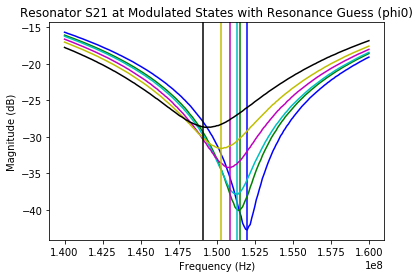

In [169]:
for i in range(n):
    plt.plot(freqs[i],mags[i], color = colors[i])
    plt.axvline(x=freqs[i][points[i]], color = colors[i])
    #plt.axvline(x=res[i], color = 'c')
plt.title('Resonator S21 at Modulated States with Resonance Guess (phi0)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

In [109]:
#Now create a function that will try to find linear portion
#seems to occur around halfway (really 3/4) between max/min and resonance
#this (3/4) value may have to be tweaked depending on quality factor
#significantly higher quality factors may need lower values and vice-vera
def slope(ang, freq, loc):
    ang_M = max(ang);
    ang_m = min(ang);
    loc_M = ang.index(ang_M)
    loc_m = ang.index(ang_m)
    half_min = round(loc_m+(loc-loc_m)*(4/5));
    half_max = round(loc_M-(loc_M-loc)*(4/5));
    lp_start = ang[half_min];
    lp_stop = ang[half_max];
    lf_start = freq[half_min];
    lf_stop = freq[half_max];
    slope = (lp_stop-lp_start)/(lf_stop-lf_start);
    #plt.plot(freq,ang)
    #plt.axvline(x=freq[half_max], color='c')
    #plt.axvline(x=freq[half_min], color='r')
    #plt.axvline(x=freq[loc])
    return slope
slopes = []
mult_facts = []
for i in range(n):
    slopes.append(slope(angs[i], freqs[i], loc[i]))
for i in range(n):
    mult_facts.append(1/slopes[i])


In [158]:
mult_facts

[11731.796421841747,
 16282.759656235212,
 20080.71378474255,
 31439.057935825116,
 43495.54759709331,
 65752.97093587386]

In [159]:
#Matplotlib doesn't have a function for slope-intercept form cuz their a bunch of pansies
#so heres a function to do it for you
def linslope(slope, intercept, ang, color):
    axes = plt.gca()
    x_vals = np.linspace(freqs[i][ang.index(min(ang))],freqs[i][ang.index(max(ang))], 100)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = color)
    
intercepts = []    
for i in range(n):
    intercepts.append(phi0[i] - slopes[i]*res[i])

Text(0, 0.5, 'Phase Angle (degrees)')

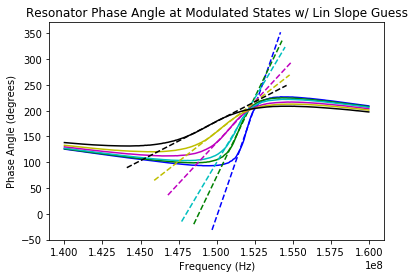

In [170]:
#replot the phase plots with slope guess
for i in range(n):
    plt.plot(freqs[i],angs[i], color = colors[i])
    linslope(slopes[i], intercepts[i], angs[i], colors[i])
plt.title('Resonator Phase Angle at Modulated States w/ Lin Slope Guess')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Angle (degrees)')

In [113]:
phi0

[164.67863918700058,
 157.8465263512474,
 169.1296476344462,
 166.60346435219077,
 163.63249540832484,
 168.47131741922834]